# Validation

We check the `Bandit` and `BernouilliArm` are properly implemented, by using
the `Oracle` to evaluate some `RandomPolicy` on this problem.

In [6]:
from project.bandit import Bandit, BernouilliArm

bandit = Bandit.generate(
    arm_class=BernouilliArm,
    arm_kwargs=(
        {'p': 0.1},
        {'p': 0.4},
        {'p': 0.6},
        {'p': 0.8},
        {'p': 0.9},
    )
)

In [7]:
from project.policy import RandomPolicy

n_policies = 3

policies = [
    RandomPolicy() for _ in range(n_policies)
]

In [8]:
from project.oracle import Oracle

oracle = Oracle(policies=policies)

In [9]:
oracle.set_bandit(bandit=bandit)

In [10]:
n_runs = 400
report = oracle.evaluate(
    n_runs=n_runs
)

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

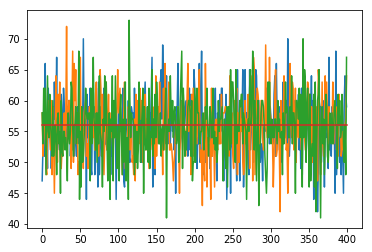

In [12]:
for i in range(n_policies):
    plt.plot(np.sum(report.results[:,i,:], axis=1))

avg_reward = np.mean([arm.p for arm in bandit.arms])
plt.plot(avg_reward * 100 * np.ones(n_runs))

# Gittins Index

$$\mathcal{G}_k(x_{k,t}) = \sup_{\tau \geq 1} \Big( \frac{\sum_{i=0}^{\tau - 1} \lambda_{k, t+i} \, d^i}{\sum_{i=0}^{\tau - 1} d^i} \quad | \; x_{k,t} \Big)$$

$$\lambda_{k,t} = \frac{s_{k,0} + s_{k,t}}{s_{k,0} + s_{k,t} + f_{k,0} + f_{k,t}}$$

**Computation method** (Largest-Remaining-Index algorithm, Varaiya, Walrand and Buyukkoc):

- Find state $x = (s, f)$ with highest expected reward $\lambda = \frac{s}{s + f}$, call it $\alpha_1$.
- For each $k$ from $2$ to $m$ (the number of considered states):
    - Compute $Q^{(k)}$ from the transition probability matrix $P$, keeping only the columns for the continuation set of $\alpha_k$, which is $(\alpha_1, \dots, \alpha_{k-1})$.
    - Compute the inverse $C^{(k)} = (I - \beta Q^{(k)})^{-1}$ (probably sparse ?)
    - Then, compute $d^{(k)} = C^{(k)} \cdot \lambda$ and $b^{(k)} = C^{(k)} \cdot 1$ (these are $m$-vectors)
    - Find the best state $a = \alpha_k$ when maximizing $\frac{d^{(k)}_a}{b^{(k)}_a}$

$$Q^{(k)}_{x, y} = 0 \; \text{when}\;  y \notin (\alpha_1, \dots, \alpha_{k-1}) \cap \mathcal{F}(x) \quad\quad \text{where} \; \mathcal{F}(x = (s, f)) = \{(s + 1, f), (s, f + 1)\}$$

Let's try to simplify the way we choose...

At step $k$, we have $m - k + 1$ candidates for $\alpha_k$. We only keep the ones in the set of predecessors for the currently saved set of states $(\alpha_1, \dots, \alpha_{k-1})$, which we note: 

$$\mathcal{P}(\alpha_1, \dots, \alpha_{k-1}) = \bigcap_i \{(s_{\alpha_i} - 1, f_{\alpha_i}), (s_{\alpha_i}, f_{\alpha_i} - 1)\} \,\backslash\, \{\alpha_1, \dots, \alpha_{k-1}\}$$

We compute $(I - \beta Q^{(k)})$ by substracting $\beta \, \mathbb{P}(\alpha_j \, | \, x)$ whenever we find a predecessor $x$ to $\alpha_j$.

Let's compute $P$:  

Suppose we have $s, f \in \{1, \dots, n\}$, then $P$ is of size $n^2 \times n^2$.  
if we note $x = n s + f$, then the row $P_x$ only contains zeros, except for $y = n s + (f + 1)$ and $y = n (s + 1) + f$

Visualizing this matrix, we can see it only shows two non-zero subdiagonals, one with an offset of 1 from the diagonal, representing the probability of failure, and another one with an offset of $n$ from the diagonal representing the successes.

First non-zero subdiagonal (offset 1) : $$P_{x, x+1} = \frac{f}{s + f} \forall s \in \{1, \dots, n\}, f \in \{1, \dots, n - 1\}$$

Second non-zero subdiagonal (offset $n$) : $$P_{x, x+n} = \frac{s}{s + f} \forall s \in \{1, \dots, n - 1\}, f \in \{1, \dots, n\}$$

In [2]:
def transition_prob(state_from, state_to):
    s_from, f_from = state_from
    s_to, f_to = state_to
    
    if (s_to - s_from) + (f_to - f_from) != 1:
        return 0
    elif s_to - s_from == 1:
        return s_from / sum(state_from)
    else:
        return f_from / sum(state_from)

In [3]:
def gen_states(n_steps):
    for n_success in range(1, n_steps + 1):
        for n_failure in range(1, n_steps + 1):
            yield (n_success, n_failure)

In [5]:
gen = gen_states(10)
for i in range(20):
    print(next(gen))

(1, 1)
(1, 2)
(1, 3)
(1, 4)
(1, 5)
(1, 6)
(1, 7)
(1, 8)
(1, 9)
(1, 10)
(2, 1)
(2, 2)
(2, 3)
(2, 4)
(2, 5)
(2, 6)
(2, 7)
(2, 8)
(2, 9)
(2, 10)


In [53]:
n_steps = 150

n_states = (
    n_steps *  # maximum number of successes
    n_steps    # maximum number of failures
)

first_diag = [
    n_failure / (n_success + n_failure)
    for n_success, n_failure in gen_states(n_steps)
][:-1]

second_diag = [
    n_success / (n_success + n_failure)
    for n_success, n_failure in gen_states(n_steps)
][:-n_steps]

In [4]:
from scipy import sparse
import numpy as np

In [8]:
data = np.zeros((2, n_states))
data[0, :-1] = first_diag
data[1, :-n_steps] = second_diag
offsets = [1, n_steps]

transition_matrix = sparse.dia_matrix(
    (data, offsets), shape=(n_states, n_states)
)

In [9]:
transition_matrix

<2500x2500 sparse matrix of type '<class 'numpy.float64'>'
	with 4949 stored elements (2 diagonals) in DIAgonal format>

So we have the transition matrix $P$, but we actually want $(I - \beta Q)$. To build it, we'll consider the following approach:

- Start with the identity matrix
- Given the set of kept states at iteration $k$ (we note it $\mathcal{S}^{(k)} = \{\alpha_1, \dots, \alpha_{k-1}\}$), we compute the set of predecessor states $\mathcal{P}(\mathcal{S}^{(k)})$
- For each predecessor $(s, f)$, we compute the related $Q$ entries, and update the subdiagonals accordingly

In [5]:
def check_pred(state, successors):
    if state in successors:
        # already seen
        return False
    
    if state[0] < 0 or state[1] < 0:
        # out of the grid
        return False
    
    return True

def get_predecessors(states):
    assert isinstance(states, set), "Expected the kept states to be a set."
    
    predecessors = set()
    for state in states:
        s_pred = (state[0] - 1, state[1])
        f_pred = (state[0], state[1] - 1)
        
        if check_pred(s_pred, states):
            predecessors.add(s_pred)
        
        if check_pred(f_pred, states):
            predecessors.add(f_pred)
    
    return predecessors

In [6]:
# let's call `c_mat` the (I - beta Q) matrix

def compute_c_mat(n_steps, states, beta=0.9):
    n_states = n_steps ** 2
    # we start with the identity matrix
    c_mat = sparse.dia_matrix((np.ones(n_states), [0]), shape=(n_states, n_states))
    
    # initialize empty subdiagonals
    subdiag_to_failure = np.zeros(n_states)
    subdiag_to_success = np.zeros(n_states)
    
    for pred in get_predecessors(states):
        s, f = pred
        pred_index = n_steps * s + f

        if (s, f + 1) in states:
            subdiag_to_failure[pred_index] = (f + 1) / (s + f + 2)
        
        if (s + 1, f) in states:
            subdiag_to_success[pred_index] = (s + 1) / (s + f + 2)
    
    c_mat.setdiag(-beta * subdiag_to_failure, 1)
    c_mat.setdiag(-beta * subdiag_to_success, n_steps)
    
    return c_mat.tocsc()  # use Compressed Sparse Column format for inversion

In [54]:
n_steps = 150

n_states = (
    n_steps *  # maximum number of successes
    n_steps    # maximum number of failures
)

# find alpha_1
alpha_1 = sorted(
    ((state, state[0]/sum(state)) for state in gen_states(n_steps)),
    key=lambda t: t[1]
)[-1][0]

alpha_1 = (alpha_1[0] - 1, alpha_1[1] - 1)  # 0-indexed arrays

In [55]:
current_states = set([alpha_1])

In [56]:
%%time
c_mat_2 = compute_c_mat(current_states)

CPU times: user 5.01 ms, sys: 0 ns, total: 5.01 ms
Wall time: 5.71 ms


In [10]:
import scipy.sparse.linalg as s_linalg

In [57]:
%%time
inv_c_mat_2 = s_linalg.inv(c_mat_2)

CPU times: user 16.2 s, sys: 8.02 ms, total: 16.2 s
Wall time: 16.2 s


In [58]:
_lambda = np.array([
    (x[0] / sum(x)) for x in gen_states(n_steps)
])

In [60]:
d_2 = inv_c_mat_2.dot(_lambda)

In [61]:
b_2 = inv_c_mat_2.dot(np.ones(n_states))

In [64]:
np.argmax(d_2 / b_2)

22350

In [65]:
n_states

22500

In [7]:
from contextlib import contextmanager
import time

@contextmanager
def timeit(key: 'default', debug=False):
    start = time.time()
    yield
    duration = time.time() - start
    if debug:
        print('({}): {:.2f}s'.format(key, duration))

In [8]:
def compute_gittins_index(n_steps, beta=0.9):
    n_states = (
        n_steps *  # maximum number of successes
        n_steps    # maximum number of failures
    )
    rewards = np.array([
        x[0] / sum(x) for x in gen_states(n_steps)
    ])
    ones = np.ones(n_states)
    
    best_states = set()
    gittins = np.zeros((n_steps, n_steps))
    
    # find the best rewarding state (alpha 1)
    alpha_1 = np.argmax(rewards)
    alpha_1_state = (alpha_1 // n_steps, alpha_1 % n_steps)
    
    best_states.add(alpha_1_state)
    gittins[alpha_1_state] = rewards[alpha_1]
    
    for i in range(1, n_states):
        if i % 100 == 99:
            print("Step {}/{}".format(i + 1, n_states))
        
        with timeit('compute C - step {}'.format(i)):
            c_mat = compute_c_mat(n_steps, best_states, beta)
        
        with timeit('inverse C - step {}'.format(i)):
            inv_c_mat = s_linalg.inv(c_mat)
        
        d = inv_c_mat.dot(rewards)
        b = inv_c_mat.dot(ones)
        d_b = d / b
        
        # mask d_b for seen states
        for s, f in best_states:
            d_b[n_steps * s + f] = 0
        
        new_best = np.argmax(d_b)
        new_best_state = (new_best // n_steps, new_best % n_steps)
        
        #print('New best state: {} (s={}, f={})'.format(new_best, *new_best_state))
        #print('Gittins value for {}: {}'.format(new_best, d_b[new_best]))
        
        best_states.add(new_best_state)
        gittins[new_best_state] = d_b[new_best]
    
    return gittins

In [11]:
folder = 'saved_gittins/'

for n_steps in (20, 40, 60, 80, 100, 150, 200, 300):
    for beta in (0.8, 0.9, 0.95, 0.99):
        print("Running for n_steps={}, beta={:.2f}".format(n_steps, beta))

        with timeit('Gittins computation ({}, {:.2f})'.format(n_steps, beta), True):
            gittins = compute_gittins_index(n_steps, beta)

        filename = '{}gittins_{}_{}.npy'.format(folder, n_steps, int(beta*100))
        np.save(filename, gittins)
        print("Saved at {}\n---\n".format(filename))

Running for n_steps=20, beta=0.80
Step 100/400
Step 200/400
Step 300/400
Step 400/400
(Gittins computation (20, 0.80)): 36.55s
Saved at saved_gittins/gittins_20_80.npy
---

Running for n_steps=20, beta=0.90
Step 100/400
Step 200/400
Step 300/400
Step 400/400
(Gittins computation (20, 0.90)): 36.37s
Saved at saved_gittins/gittins_20_90.npy
---

Running for n_steps=20, beta=0.95
Step 100/400
Step 200/400
Step 300/400
Step 400/400
(Gittins computation (20, 0.95)): 36.47s
Saved at saved_gittins/gittins_20_95.npy
---

Running for n_steps=20, beta=0.99
Step 100/400
Step 200/400
Step 300/400
Step 400/400
(Gittins computation (20, 0.99)): 36.45s
Saved at saved_gittins/gittins_20_99.npy
---

Running for n_steps=40, beta=0.80
Step 100/1600
Step 200/1600
Step 300/1600
Step 400/1600
Step 500/1600
Step 600/1600
Step 700/1600
Step 800/1600
Step 900/1600
Step 1000/1600
Step 1100/1600
Step 1200/1600
Step 1300/1600
Step 1400/1600
Step 1500/1600
Step 1600/1600
(Gittins computation (40, 0.80)): 671.28s
S

KeyboardInterrupt: 

In [113]:
gittins[0:5, 0:5].T

array([[ 0.55518395,  0.6997992 ,  0.7713056 ,  0.81473214,  0.84409654],
       [ 0.37468672,  0.53311037,  0.62484316,  0.68559954,  0.7290795 ],
       [ 0.27975952,  0.42836676,  0.52365026,  0.59078467,  0.64092664],
       [ 0.22203673,  0.35696384,  0.44984955,  0.51839465,  0.57132616],
       [ 0.18352749,  0.30540089,  0.39380128,  0.46141975,  0.51505017]])

In [23]:
v1 = 36 / 20**6
print('{:e}'.format(v1))

v2 = 670 / 40**6
print('{:e} (+ {:e})'.format(v2, v2 - v1))

v3 = 4090 / 60**6
print('{:e} (+ {:e})'.format(v3, v3 - v1))

5.625000e-07
1.635742e-07 (+ -3.989258e-07)
8.766289e-08 (+ -4.748371e-07)


We used an "offline" algorithm (highly expensive, $\mathcal{O}(T^6)$) to compute the index. However, it seems another approach might be much more efficient:

- **Whittle** constructed an alternative problem of the MAB, with a _retirement option_, i.e. whenever during the bandit process, a player can stop drawing arms and receive only once a retirement reward.

$$\mathbf{v}_{s,f}^{(M)} = \max \{ \mathbf{w}_{s,f}^{(M)}, M \}$$

$$\mathbf{w}_{s,f}^{(M)} = \frac{s}{s+f} [\mathbf{1} + \beta \mathbf{v}^{(M)}_{s+1, f}] + \frac{f}{s+f} \beta \mathbf{v}_{s, f+1}^{(M)}$$

- Using this optimality equation for the alternative MDP, we can apply the usual dynamic programming methods to approximate the optimal value function $\mathbf{v}^{(M)}$, and deduce the Gittins index using:

$$\nu(s, f) = (1 - \beta) M_{s, f}$$

$$M_{s, f} = \min_{s,f} \{ M \;|\;\; M = \mathbf{v}_{s, f}^{(M)} = \mathbf{w}_{s, f}^{(M)} \}$$

__Gittins approach__: apply _value iteration_ to the optimality equation on $v^{(M)}$, for multiple values of M.

### Reminder on value iteration

Bellman equation for the classical MDP formulation:
 $$v_*(s) = \max_a \mathbb{E} [ R_{t+1} + \beta v_*(S_{t+1}) \; | \; S_t = s, A_t = a ]$$
 
From this equation, we can derive an iterative algorithm, called _value iteration_:

- Initalize arbitrarily the value function $V$ for all states
- Until we reach a progression threshold (lower bound on the update), repeat:
    - for all states $s$, update $V_{i + 1}(s) = \max_a \mathbb{E} [ R_{t+1} + \beta V_i(S') ]$
    - _note: $S'$ is the successor random state of the state $s$._
- From the latest value function obtained $V_I$, we can define a deterministic policy called "greedy":

$$\pi^*(s) = \arg \max_a \mathbb{E} [ R_{t+1} + \beta V_i(S') ]$$

In [1]:
from warnings import warn
from itertools import chain

class CallableMapping:
    def __init__(self, func):
        self.func = func
        self._cache = {}
    
    def __getitem__(self, key):
        if key in self._cache:
            return self._cache[key]
        
        val = self.func(key[:-1], key[-1]) # split state and action
        self._cache[key] = val
        
        return val

def flatten(*args):
    """Combine two values (int or tuple) into a single flat tuple.

    assert combine(1, 2) == (1, 2)
    assert combine((1, 2), 3) == (1, 2, 3)
    assert combine(1, (2, 3)) == (1, 2, 3)
    assert combine((1,), 2) == (1, 2)
    assert combine((1, 2), (3, 4)) == (1, 2, 3, 4)
    assert combine(1, 2, 3, (4, 5)) == (1, 2, 3, 4, 5)
    """
    _vals = [(v,) if isinstance(v, int) else v for v in args]
    return tuple(chain(*_vals))

In [2]:
class ValueIteration:
    """Flexible implementation of the value iteration algorithm."""

    # Allowed keys for configuration of the algorithm
    CONFIG_KEYS = frozenset((
        'expected_reward',
        # Expected reward (no default): can be provided as a function of
        # state and action, or as a numpy array of same shape as the value
        # function, with an extra dimension for action (assume a non-negative
        # integer).
        'n_actions',
        # Number of actions (no default): may be inferred from expected_reward
        # if it was provided as a numpy array, as its last dimension.
        # Else, this value MUST be set.
        'transition',
        # Transition dynamics (no default): can be set as a numpy array of
        # shape (value_shape, n_actions, value_shape), or as a generator
        # function, taking a state and an action as arguments and yielding
        # non-zero probabilities with according follower state.
        'init_value',
        # Initial value for the value function (default: 0)
        'discount',
        # Discount for ahead of time rewards (default: 0.9)
        'synchronous_updates'
        # Whether to update the value function synchronously or not
        # (default: False) not synchronous, value is updated immediately
    ))
    
    def __init__(self, shape: 'Union[int, tuple]', **kwargs):
        self.value_shape = shape
        
        kwargs.setdefault('init_value', 0)
        kwargs.setdefault('discount', 0.9)
        kwargs.setdefault('synchronous_updates', False)
        self.configure(**kwargs)

    def configure(self, **kwargs):
        invalid_keys = set(kwargs) - self.CONFIG_KEYS
        if invalid_keys:
            raise ConfigError(
                'Invalid keys: {}'.format(', '.join(invalid_keys))
            )

        for key, value in kwargs.items():
            setattr(self, key, value)
            
        if 'transition' not in kwargs:
            warn('Transition dynamics should be provided before running.')
        
        if not hasattr(self, 'expected_reward'):
            warn('`expected_reward` should be set before running.')
        elif callable(self.expected_reward) and \
                not hasattr(self, 'n_actions'):
            warn(
                '`expected_reward` was provided as a function, so you should'
                ' configure `n_actions` explicitly too.'
            )
    
    @property
    def expected_reward(self):
        return self._expected_reward
    
    @expected_reward.setter
    def expected_reward(self, value):
        if callable(value):
            self._expected_reward = CallableMapping(value)
        else:
            assert value.shape[:-1] == self.value_shape
            self._expected_reward = value
            self.n_actions = value.shape[-1]
    
    @property
    def transition(self):
        return self._transition
    
    @transition.setter
    def transition(self, value):
        if callable(value):
            self.transition_mode = 'generator'
        else:
            assert value.shape == flatten(
                self.value_shape, self.n_actions, self.value_shape)
            self.transition_mode = 'matrix'
        
        self._transition = value
    
    def run(self, threshold=None):
        values = self.init_value * np.ones(self.value_shape)

        if threshold is None:
            threshold = getattr(self, 'progression_threshold', 1e-3)
        
        delta = threshold * 2
        
        while delta >= threshold:
            delta = 0

            for state, value in self.iter_values(values):
                new_value = max(
                    self.get_update(state, action, values)
                    for action in self.iter_actions()
                )
                delta = max(delta, np.abs(value - new_value))
                values[state] = new_value
        
        return values
    
    def get_update(self, state, action, values):
        return self.expected_reward[flatten(state, action)] + sum(
            prob * values[next_state]
            for prob, next_state in self.get_next_state(state, action)
        )
    
    def get_next_state(self, state, action):
        assert hasattr(self, '_transition'), (
            'One of two transition dynamics descriptions must be '
            'configured.'
        )
            
        if self.transition_mode == 'matrix':
            for next_state, prob in self._iter_array(
                self.transition[flatten(state, action)]
            ):
                if prob == 0:
                    continue
                yield prob, next_state

        elif self.transition_mode == 'generator':            
            return self.transition(state, action)
        
        else:
            warn('Should not get in this state: no transition dynamics.')
    
    def iter_actions(self):
        return range(self.n_actions)
    
    def iter_values(self, values):
        if self.synchronous_updates:
            _vals = values.copy()
        else:
            _vals = values
        
        return self._iter_array(_vals)

    @staticmethod
    def _iter_array(array):
        iterator = np.nditer(array, flags=['multi_index'])
        for v in iterator:
            yield iterator.multi_index, v

Let's use this algorithm directly on the Bayesian Bernouilli MAB:

In [3]:
# We first set the total number of steps to compute
n_steps = 1000

def _next(state, direction):
    if direction == 's':
        return (state[0] + 1, state[1])
    elif direction == 'f':
        return (state[0], state[1] + 1)
    else:
        raise ValueError('Invalid direction: {}'.format(direction))

def _get_prob(state, direction):
    ns, nf = state[0] + 1, state[1] + 1
    if direction == 's':
        return ns / (ns + nf)
    elif direction == 'f':
        return nf / (ns + nf)
    else:
        raise ValueError('Invalid direction: {}'.format(direction))

def transition_gen(state, action):
    # we assume action is always 0
    
    # check extremities
    if sum(state) == n_steps:
        yield 0, 0
    else:
        for direction in ('s', 'f'):
            yield _get_prob(state, direction), _next(state, direction)

def expected_reward(state, action):
    # action always 0
    
    return _get_prob(state, 's')

In [4]:
VI = ValueIteration((n_steps, n_steps),
    transition=transition_gen,
    expected_reward=expected_reward,
    n_actions=1
)

In [13]:
values = VI.run()

In [14]:
x, y = np.arange(n_steps), np.arange(n_steps)
X, Y = np.meshgrid(x, y)

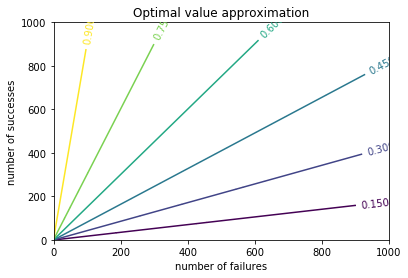

In [16]:
%matplotlib inline
plt.figure()

CS = plt.contour(X, Y, values)

plt.clabel(CS, inline=1, fontsize=10)

plt.ylabel('number of successes')
plt.xlabel('number of failures')
plt.title('Optimal value approximation')

plt.show()

Using this value approximation, we can evaluate a Policy using this value on the Bandit.

In [17]:
from project import policy

In [54]:
class VIPolicy(policy.Policy):
    """Greedy policy from the value function approximated before."""
    def prepare(self, n_arms, n_steps, **kwargs):
        self.states = [(0, 0) for _ in range(n_arms)]
        self.values = values[:n_steps, :n_steps]
    
    def pick(self):
        #print(self.states)
        values = [self.values[state] for state in self.states]
        #print(values)
        best_arm = np.argmax(values)
        #print('Selected arm: {}'.format(best_arm))
        return best_arm
    
    def receive(self, arm, reward):
        #print('Received reward: {}'.format(reward))
        self.states[arm] = _next(self.states[arm], 's' if reward else 'f')

class EpsVIPolicy(VIPolicy):
    """Epsilon-greedy variant."""
    def __init__(self, epsilon=1e-2, **kwargs):
        super().__init__(**kwargs)
        self.epsilon = epsilon

    def pick(self):
        if self._random.rand() <= self.epsilon:
            return self._random.randint(len(self.states))
        
        return super().pick()

In [55]:
policies = [
    VIPolicy(),
    EpsVIPolicy(),
    policy.UCBPolicy(delta=2),
    policy.RandomPolicy()
]

In [56]:
from project.oracle import Oracle

oracle = Oracle(policies=policies)
oracle.set_bandit(bandit)

In [57]:
report = oracle.evaluate(
    n_runs=500,
    run_length=1000
)

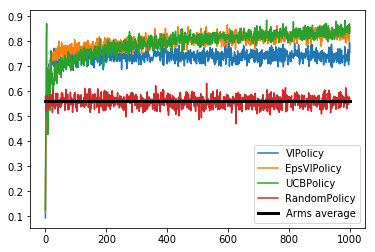

In [61]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

policies_cls = [str(p.__class__.__name__) for p in policies]
for i, name in enumerate(policies_cls):
    plt.plot(np.mean(report.results[:,i,:], axis=0), label=name)

# Using the bandit object, we compute its mean expected reward across all
# arms.
avg_reward = np.mean([arm.p for arm in bandit.arms])
plt.plot(avg_reward * np.ones(1000),
         color='black', label='Arms average', linewidth=3)

plt.legend()

We now need to use VI to compute the Gittins index.